In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
import tensorflow_federated as tff

import matplotlib.pyplot as plt

2024-08-28 14:51:51.816379: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-28 14:51:51.971380: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-28 14:51:51.971408: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-28 14:51:51.972307: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-28 14:51:52.054280: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-28 14:51:52.055228: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

In [2]:
NUMBER_TO_LABEL = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

In [3]:
SAVE_DIR = Path("/home/ole/masterarbeit/flidp/dataset-cache/cifar10")

In [23]:
train_ds = tfds.load("cifar10", split="train")
test_ds = tfds.load("cifar10", split="test")

In [24]:
train_df = tfds.as_dataframe(train_ds)
test_df = tfds.as_dataframe(test_ds)
len(train_df), len(test_df)

(50000, 10000)

In [25]:
TRAIN_CLIENTS = 500
TEST_CLIENTS = 100

In [35]:
train_label_counts = train_df['label'].sort_values().value_counts().to_numpy()
test_label_counts = test_df['label'].sort_values().value_counts().to_numpy()

train_label_counts, test_label_counts

(array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]),
 array([1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]))

In [18]:
def init_client_distributions(num_clients, label_counts):
    return np.random.dirichlet(label_counts / sum(label_counts), size=num_clients)

In [19]:
def init_client_labels(num_clients, examples_per_label):
    """Assigns labels to clients by giving a label distribution to each client that is drawn from a dirichlet distribution."""
    assert min(examples_per_label) > 0, "There are some labels that don't have any examples!"
    examples_per_label = examples_per_label.copy()
    labels = np.array(range(len(examples_per_label))).astype(int)
    client_labels = np.zeros((num_clients, len(labels))).astype(int)
    current_client = 0
    while len(labels) > 0:
        client_distributions = init_client_distributions(num_clients, examples_per_label)
        while min(examples_per_label) > 0:
            new_label = np.random.choice(labels, p=client_distributions[current_client])
            new_label_pos = np.argwhere(labels == new_label) 
            examples_per_label[new_label_pos] -= 1
            client_labels[current_client][new_label] += 1
            current_client = (current_client + 1) % num_clients
        empty_label = labels[np.argmin(examples_per_label)]
        labels = labels[np.where(labels != empty_label)]
        examples_per_label = examples_per_label[examples_per_label > 0]

    return client_labels

In [20]:
def assign_examples_to_clients(client_labels, df):
    """Assigns each example to a random client that has a count for the example's label > 0. Returns a list of those assignments"""
    assert np.sum(client_labels) == len(df), "The total number of examples mismatch."
    client_labels = client_labels.copy()
    client_assignments = []
    for i in range(len(df)):
        ex = df.iloc[i]
        label = ex['label']
        clients_for_label = client_labels[:, label]
        possible_clients = np.argwhere(clients_for_label > 0).reshape(-1)
        selected_client = np.random.choice(possible_clients)
        client_assignments.append(selected_client)
        client_labels[selected_client, label] -= 1    
    
    assert np.all(client_labels == 0)

    return client_assignments

In [21]:
def assign_clients_to_df(df, num_clients):
    label_counts = df['label'].sort_values().value_counts().to_numpy()
    client_labels = init_client_labels(num_clients, label_counts)
    client_assignments = assign_examples_to_clients(client_labels, df)
    df['client_ids'] = pd.Series(client_assignments).map(lambda x: f"client_{x}")

    return df

In [26]:
train_df = assign_clients_to_df(train_df, TRAIN_CLIENTS)
test_df = assign_clients_to_df(test_df, TEST_CLIENTS)

In [41]:
def make_client_getter(df):
    def get_tf_dataset_for_client(client_id):
        client_df = df[df['client_ids'] == client_id]
        client_images = tf.convert_to_tensor(client_df['image'].to_list(), dtype=tf.int64)
        client_labels = tf.convert_to_tensor(client_df['label'].to_list(), dtype=tf.int64)
        
        client_ds = tf.data.Dataset.from_tensor_slices(
            {
                'image': client_images[:], 
                'label': client_labels[:],
            }
        )
        return client_ds
    return get_tf_dataset_for_client

In [196]:
tff.simulation.datasets.save_to_sql_client_data(
    client_ids=train_df['client_ids'].unique(),
    dataset_fn=make_client_getter(train_df),
    database_filepath=str(SAVE_DIR / 'train.sqlite'),
    allow_overwrite=True,
)

In [197]:
tff.simulation.datasets.save_to_sql_client_data(
    client_ids=test_df['client_ids'].unique(),
    dataset_fn=make_client_getter(test_df),
    database_filepath=str(SAVE_DIR / 'test.sqlite'),
    allow_overwrite=True,
)

In [7]:
def load_cifar10(dir: str):
    tensor_spec = {
        'image': tf.TensorSpec((32, 32, 3), dtype=tf.int64),
        'label': tf.TensorSpec((), dtype=tf.int64),
    }
    train_client_data =  tff.simulation.datasets.load_and_parse_sql_client_data(str(Path(dir) / 'train.sqlite'), element_spec=tensor_spec, split_name=None)
    test_client_data = tff.simulation.datasets.load_and_parse_sql_client_data(str(Path(dir) / 'test.sqlite'), element_spec=tensor_spec, split_name=None)
    return train_client_data, test_client_data

In [8]:
fed_train_ds, fed_test_ds = load_cifar10(SAVE_DIR)

(<matplotlib.image.AxesImage at 0x7f45921ae710>, 'ship')

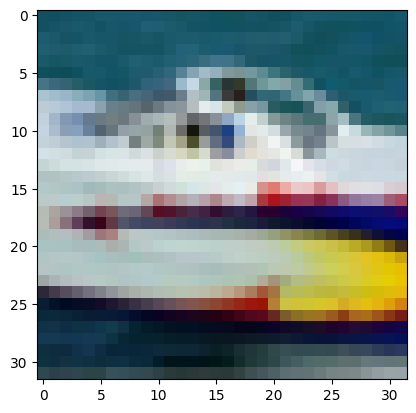

In [9]:
client_id = "client_23"
client_ds = fed_train_ds.create_tf_dataset_for_client(client_id)
client_example = next(client_ds.as_numpy_iterator())
plt.imshow(client_example['image']), NUMBER_TO_LABEL[client_example['label']]

In [27]:
def plot_label_dist_for_clients(label_df, client_ids):
    label_counts = (
        label_df
        .groupby(['client_ids', 'label'])
        .value_counts()
        .reset_index()
        .pivot(index='client_ids', columns='label', values='count')
        .fillna(0)
    )

    def prepare_axis(ax, ax_num):
        if not (ax_num == 0):
            ax.tick_params(left=False)
            ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # ax.tick_params(labelbottom=False)

    fig = plt.figure(figsize=(15,5))
    axes = fig.subplots(ncols=len(client_ids), sharey=True, sharex=True, squeeze=True)
    for i, ax in enumerate(axes):
        prepare_axis(ax, i)
    for ax, (cid, labels) in zip(axes, label_counts.loc[client_ids].iterrows()):
        labels.plot(kind='bar', sharey=True, sharex=True, fig=fig, ax=ax, title=f"Client {cid}", xlabel='')

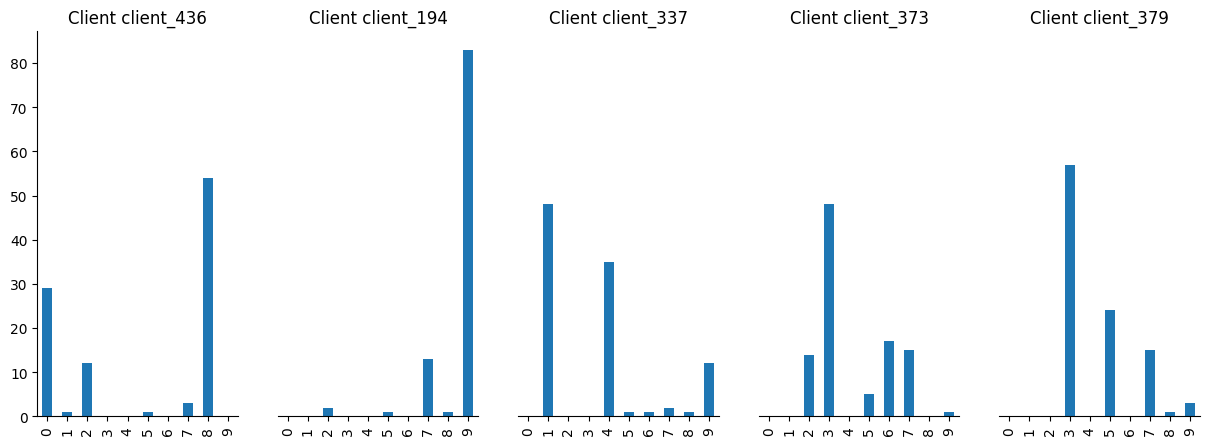

In [28]:
viz_clients = np.random.choice(train_df['client_ids'].unique(), size=5, replace=False).tolist()
plot_label_dist_for_clients(train_df[['client_ids', 'label']], viz_clients)

# Build IID version

In [41]:
def make_clientdata_iid(tff_ds: tff.simulation.datasets.ClientData, seed: int=None) -> tff.simulation.datasets.ClientData:
    if seed:
        np.random.seed(seed)
    global_ds = tff_ds.create_tf_dataset_from_all_clients()
    client_ids = tff_ds.client_ids
    client_assignments = dict(zip(tff_ds.client_ids, [{k: list() for k in global_ds.element_spec.keys()} for _ in tff_ds.client_ids]))
    for ex in global_ds:
        client = np.random.choice(client_ids)
        for k in client_assignments[client].keys():
            client_assignments[client][k].append(ex[k])

    client_datasets = {
        client_id: tf.data.Dataset.from_tensor_slices(client_assignments[client_id])
        for client_id in client_ids
    }
    
    def client_fn(client_id):
        return client_datasets[client_id]
    
    return tff.simulation.datasets.ClientData.from_clients_and_tf_fn(client_ids=client_ids, serializable_dataset_fn=client_fn)

In [42]:
iid_train_ds = make_clientdata_iid(fed_train_ds)

(<matplotlib.image.AxesImage at 0x7f44e3bd95d0>,
 <tf.Tensor: shape=(), dtype=int64, numpy=8>)

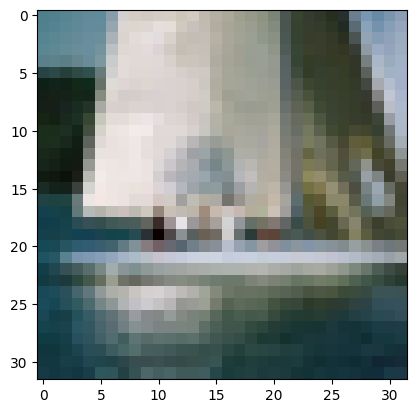

In [49]:
ex = next(iter(iid_train_ds.create_tf_dataset_for_client(iid_train_ds.client_ids[100])))
plt.imshow(ex['image']), ex['label']

In [43]:
viz_client_labels = {
    c: list(map(lambda x: x['label'].numpy(), iid_train_ds.create_tf_dataset_for_client(c)))
    for c in viz_clients
}

viz_label_counts = {
    k: [v.count(i) for i in sorted(set(v))]
    for k, v in viz_client_labels.items()
}

In [44]:
def plot_label_dist_for_clients(label_counts_per_client: dict[str, list[int]]):

    def prepare_axis(ax, ax_num):
        if not (ax_num == 0):
            ax.tick_params(left=False)
            ax.spines['left'].set_visible(False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # ax.tick_params(labelbottom=False)

    fig = plt.figure(figsize=(15,5))
    axes = fig.subplots(ncols=len(label_counts_per_client), sharey=True, sharex=True, squeeze=True)
    for i, ax in enumerate(axes):
        prepare_axis(ax, i)
    for ax, (cid, labels) in zip(axes, label_counts_per_client.items()):
        labels = pd.Series(labels, name='labels')
        labels.plot(kind='bar', sharey=True, sharex=True, fig=fig, ax=ax, title=f"Client {cid}", xlabel='')
        

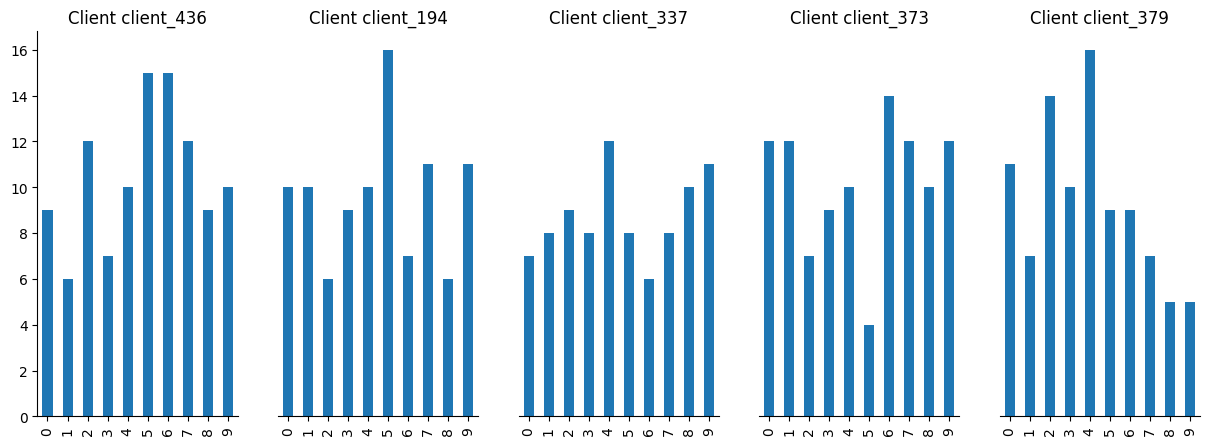

In [45]:
plot_label_dist_for_clients(viz_label_counts)

In [24]:
# This function samples randomly shuffled datasets of the same size -> not exactly what I want(?)
iid_ds = tff.simulation.datasets.build_synthethic_iid_datasets(fed_train_ds, client_dataset_size=100)
for client_ds in iid_ds:
    print(next(iter(client_ds['image'])))
    break

tf.Tensor(
[[[239 237 248]
  [238 236 244]
  [239 238 244]
  ...
  [247 243 248]
  [237 240 245]
  [146 168 191]]

 [[242 240 249]
  [238 238 243]
  [240 239 243]
  ...
  [255 252 250]
  [242 246 247]
  [148 171 188]]

 [[245 244 250]
  [243 242 246]
  [244 244 245]
  ...
  [255 254 250]
  [246 250 249]
  [152 176 190]]

 ...

 [[136 130 130]
  [133 127 127]
  [125 119 119]
  ...
  [ 75  93 101]
  [ 76  88 101]
  [ 94 121 144]]

 [[134 128 128]
  [136 130 130]
  [133 127 127]
  ...
  [ 93 128 139]
  [ 43  79  96]
  [ 54 104 129]]

 [[133 127 127]
  [135 129 129]
  [136 130 130]
  ...
  [ 88 118 135]
  [100 143 164]
  [ 72 131 157]]], shape=(32, 32, 3), dtype=int64)


2024-08-24 11:41:10.807755: W tensorflow/core/framework/dataset.cc:959] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
